<a href="https://colab.research.google.com/github/pankajdpatil/public_projects/blob/main/census_lululemon_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of demographic composition on Lululemon Sales
---
This study aims to explore how the demographic composition of surrounding areas influences store operations, offering insights applicable to retailer success factors.

**1. Initial Setup**

We install necessary packages, import relevant modules, and define custom functions


In [ ]:
# Install necessary packages
!pip install geodatasets
!pip install censusdis

In [1]:
# Import relevant modules
import censusdis.data as ced
from censusdis import states
import censusdis.maps as cem
import geopandas

In [2]:
# Define the functions which will be used often

# Get the geo dataframe with US state boundries
gdf_states = ced.download(
    dataset='acs/acs5',
    vintage=2020,
    download_variables=['NAME'],

    # All the states, as we have done before
    state="*",

    with_geometry=True
)

# Function to plot the data on the US map
def plot(df, metric_name, title, min, max):
  # Plot them on the map
  ax = cem.plot_us(
      gdf_states,
      color='beige',
      edgecolor='darkgrey',
      figsize=(12,6)
  )

  ax = cem.plot_us(
      df,
      metric_name,

      cmap='autumn',
      edgecolor='#333',
      linewidth=0.5,
      vmin=min,
      vmax=max,

      legend=True,

      ax=ax
  )

  ax.axis('off')
  _ = ax.set_title(title)

**2. Get LULU store details**

We need to understand where the Lululemon stores are located in North America, as well as some key measures for them such as weekly sales and square footage. We have downloaded this data as cs file from "retail north america" dataset on Bloomberg GeoEngine. We will now attempt to read that data as geopandas dataframe.

In [4]:
# Get store details for all LULU stores in North America
gdf_lulu = geopandas.read_file('location_of_my_file/lululemon_store_locations.csv')
gdf_lulu = gdf_lulu.replace('', None)
gdf_lulu.square_footage = gdf_lulu.square_footage.astype('Int64')
gdf_lulu.store_weekly_volume = gdf_lulu.store_weekly_volume.astype('Int64')
gdf_lulu =gdf_lulu.set_crs("EPSG:4269")
print(gdf_lulu.count())

company                363
WKT                    363
square_footage         352
state                  363
store_weekly_volume    305
street_address         363
type                   363
start_time             363
end_time               363
geometry               363
dtype: int64


,company,WKT,square_footage,state,store_weekly_volume,street_address,type,start_time,end_time,geometry
57,Lululemon Athletica Inc.,POINT(-118.4945467 34.0146189),5800,CA,188520,1457 3rd Street Promenade,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00,POINT (-118.49455 34.01462)
350,Lululemon Athletica Inc.,POINT(-73.9633732 40.7655466),3000,NY,138240,1127 3rd Ave,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00,POINT (-73.96337 40.76555)
305,Lululemon Athletica Inc.,POINT(-73.9831866 40.7685526),3200,NY,127750,10 COLUMBUS CIR,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00,POINT (-73.98319 40.76855)
349,Lululemon Athletica Inc.,POINT(-73.9785781 40.7573101),3000,NY,124140,592 5th Avenue,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00,POINT (-73.97858 40.75731)
303,Lululemon Athletica Inc.,POINT(-73.9987472 40.7226594),3000,NY,117810,520 Broadway,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00,POINT (-73.99875 40.72266)


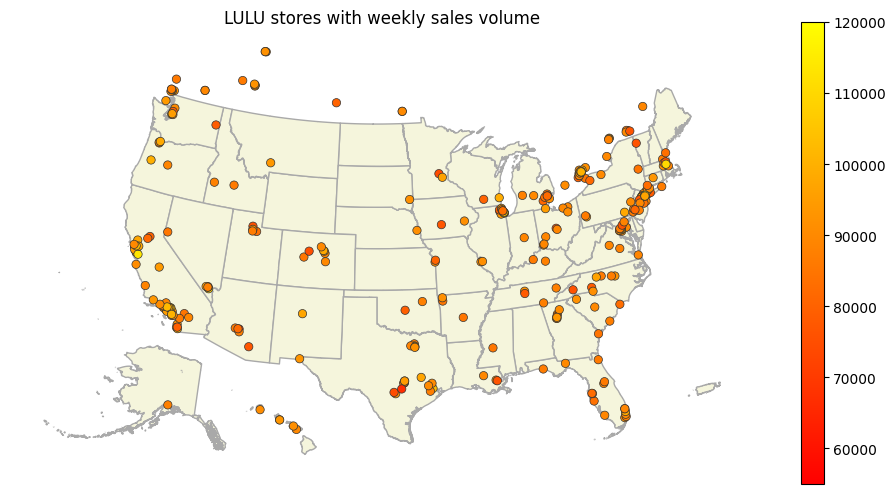

In [6]:
# Plot the LULU stores on the map, color coded per the weekly sales for each store
plot(gdf_lulu, 'store_weekly_volume', 'LULU stores with weekly sales volume',
      55000, 120000)
gdf_lulu.nlargest(5, 'store_weekly_volume')

**3. Get demographic data from US Census Bureau**

The US Census Bureau offers comprehensive demographic data for diverse localities across the USA, ranging from national and state levels to granular levels such as core-based statistical areas, school districts, census block groups, and census tracts. To facilitate data access, we utilize the CensusDis package developed by the bureau.

In [ ]:
# Download American Community Survey data from Census Bureau
# We use CensusDis package for retrieving the data
# We are interested in total population, and median household income
gdf_cbsa = ced.download(
    # These first three arguments are positional and required
    # so sometimes I skip naming them.
    dataset='acs/acs5',
    vintage=2020,

    # Note: 'B03002_001E' is the variable for total population.
    # B03002_001E is the vaiable for median household income
    # B01002_003E is the variable for median age for females
    download_variables=['NAME', 'B19013_001E', 'B03002_001E', 'B01002_003E'],

    # Query all CBSAs in the country.
    metropolitan_statistical_area_micropolitan_statistical_area='*',

    with_geometry=True
)

# Rename some columns
gdf_cbsa = gdf_cbsa.rename(
    columns={
        'METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA': 'cbsa_code',
        'B19013_001E': 'median_household_income',
        'B03002_001E': 'popuation',
        'B01002_003E': 'median_female_age',
        })

,cbsa_code,NAME,median_household_income,popuation,median_female_age,geometry
843,45540,"The Villages, FL Metro Area",59618,129938,68.5,"POLYGON ((-82.31170 28.96039, -82.24981 28.960..."
700,39460,"Punta Gorda, FL Metro Area",52724,185926,60.1,"POLYGON ((-82.37499 26.94562, -82.36512 26.946..."
382,26140,"Homosassa Springs, FL Metro Area",45689,147938,57.5,"MULTIPOLYGON (((-82.75733 28.80073, -82.75115 ..."
118,15060,"Brookings, OR Micro Area",53174,22889,56.9,"MULTIPOLYGON (((-124.32389 42.06665, -124.3232..."
693,39150,"Prescott Valley-Prescott, AZ Metro Area",53329,232396,55.6,"POLYGON ((-113.33394 34.67732, -113.33310 34.6..."


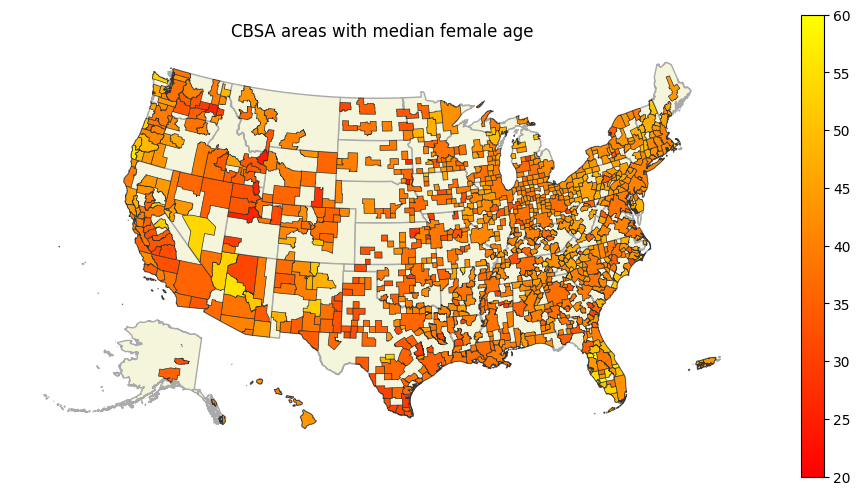

In [ ]:
# Quality check - top five cbsa ranked by median female age
plot(gdf_cbsa, 'median_female_age', 'CBSA areas with median female age', 20, 60)
gdf_cbsa.nlargest(5, 'median_female_age')

,cbsa_code,NAME,median_household_income,popuation,median_female_age,geometry
608,35620,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",81951,19261570,40.3,"MULTIPOLYGON (((-72.03769 41.25128, -72.03472 ..."
499,31080,"Los Angeles-Long Beach-Anaheim, CA Metro Area",76399,13211027,38.3,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."
163,16980,"Chicago-Naperville-Elgin, IL-IN-WI Metro Area",74621,9478801,38.9,"POLYGON ((-88.94215 42.06505, -88.93894 42.065..."
212,19100,"Dallas-Fort Worth-Arlington, TX Metro Area",72882,7451858,35.8,"POLYGON ((-98.06673 32.56236, -98.06560 32.595..."
388,26420,"Houston-The Woodlands-Sugar Land, TX Metro Area",69328,6979613,35.3,"MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ..."


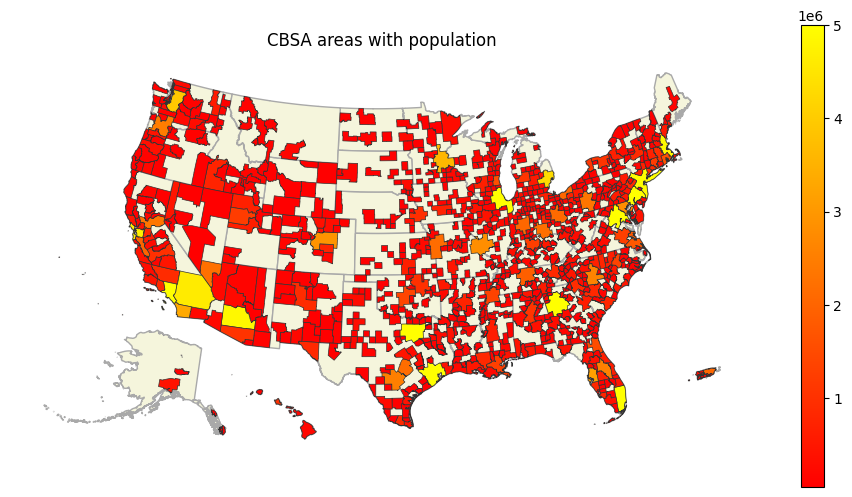

In [ ]:
# Quality check - top five cbsa ranked by population
plot(gdf_cbsa, 'popuation', 'CBSA areas with population', 50000, 5000000)
gdf_cbsa.nlargest(5, 'popuation')

,cbsa_code,NAME,median_household_income,popuation,median_female_age,geometry
759,41940,"San Jose-Sunnyvale-Santa Clara, CA Metro Area",129343,1985926,38.4,"POLYGON ((-122.20259 37.36272, -122.20132 37.3..."
498,31060,"Los Alamos, NM Micro Area",119266,18976,42.7,"POLYGON ((-106.41855 35.82074, -106.41733 35.8..."
757,41860,"San Francisco-Oakland-Berkeley, CA Metro Area",110837,4709220,40.1,"MULTIPOLYGON (((-122.37768 37.83046, -122.3734..."
896,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",106415,6250309,38.1,"POLYGON ((-78.45280 38.47553, -78.44876 38.482..."
116,14860,"Bridgeport-Stamford-Norwalk, CT Metro Area",97539,944306,42.1,"MULTIPOLYGON (((-73.21717 41.14391, -73.21611 ..."


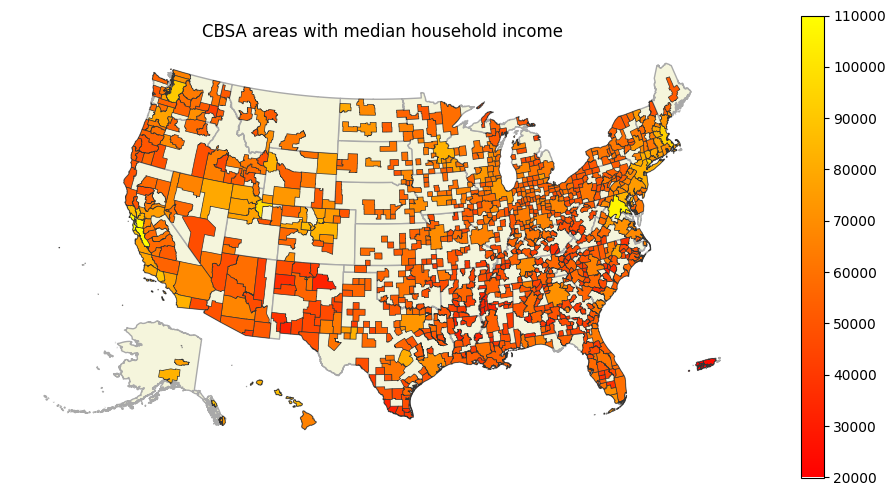

In [ ]:
# Quality check - top five cbsa ranked by median household income
plot(gdf_cbsa, 'median_household_income', 'CBSA areas with median household income', 20000, 110000)
gdf_cbsa.nlargest(5, 'median_household_income')

**4. Find the CBSAs which hae LULU stores**

We use spatial join to find the intersection between CBSAs and LULU stores, and create a geopandas dataframe which joins the two datasets.

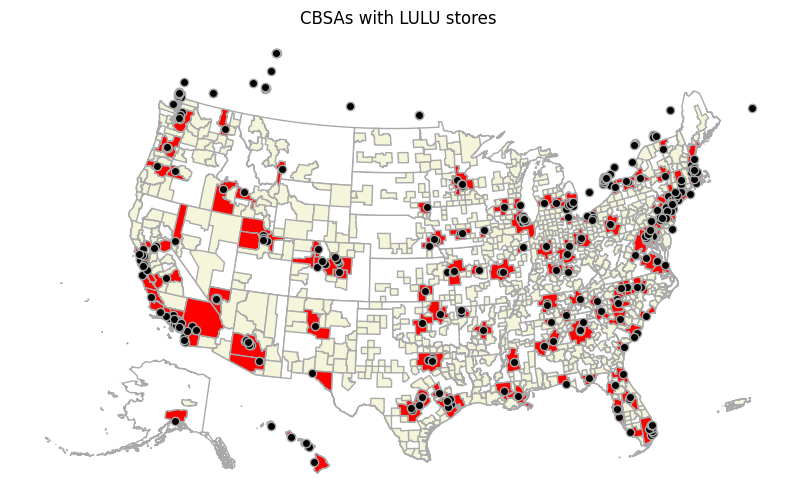

In [ ]:
# Plot the CBSAs and LULU store locations in the same map for isual inspection

gdf_lulu_cbsas = gdf_cbsa.sjoin(gdf_lulu)
gdf_lulu_cbsas = gdf_lulu_cbsas.to_crs("EPSG:4269")

# Plot them on the map
ax = cem.plot_us(
    gdf_states,
    color='white',
    edgecolor='darkgrey',
    figsize=(12,6)
)

ax = cem.plot_us(
    gdf_cbsa,
    color='beige',
    edgecolor='darkgrey',
    figsize=(12,6),
    ax=ax
)

ax = cem.plot_us(
    gdf_lulu_cbsas,
    color='red',
    edgecolor='darkgrey',
    figsize=(12,6),
    ax=ax
)

ax = cem.plot_us(
    gdf_lulu,
    color='black',
    edgecolor='darkgrey',
    figsize=(12,6),
    ax=ax
)


ax.axis('off')
_ = ax.set_title("CBSAs with LULU stores")

#print(gdf_lulu_cbsas.count())
#gdf_lulu_cbsas.nlargest(5, 'store_weekly_volume')

In [ ]:
# Find which stores have the most sales
# Important thing to note is that we now have the demographic data for the CBSA
# along with the store metrics
gdf_lulu_cbsas.nlargest(5, 'store_weekly_volume')

,cbsa_code,NAME,median_household_income,popuation,median_female_age,geometry,index_right,company,WKT,square_footage,state,store_weekly_volume,street_address,type,start_time,end_time
499,31080,"Los Angeles-Long Beach-Anaheim, CA Metro Area",76399,13211027,38.3,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",57,Lululemon Athletica Inc.,POINT(-118.4945467 34.0146189),5800,CA,188520,1457 3rd Street Promenade,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00
608,35620,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",81951,19261570,40.3,"MULTIPOLYGON (((-72.03769 41.25128, -72.03472 ...",350,Lululemon Athletica Inc.,POINT(-73.9633732 40.7655466),3000,NY,138240,1127 3rd Ave,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00
608,35620,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",81951,19261570,40.3,"MULTIPOLYGON (((-72.03769 41.25128, -72.03472 ...",305,Lululemon Athletica Inc.,POINT(-73.9831866 40.7685526),3200,NY,127750,10 COLUMBUS CIR,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00
608,35620,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",81951,19261570,40.3,"MULTIPOLYGON (((-72.03769 41.25128, -72.03472 ...",349,Lululemon Athletica Inc.,POINT(-73.9785781 40.7573101),3000,NY,124140,592 5th Avenue,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00
608,35620,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",81951,19261570,40.3,"MULTIPOLYGON (((-72.03769 41.25128, -72.03472 ...",303,Lululemon Athletica Inc.,POINT(-73.9987472 40.7226594),3000,NY,117810,520 Broadway,Apparel Stores,2024-03-30T00:00:36.111996+00:00,2024-03-30T00:00:36.111996+00:00


**5. Aggregate the store metrics to CBSA level**

We used the demographic numbers for CBSA. It would then make sense to also aggregate the store metrics to CBSA level.

In [ ]:
# We use geopandas dissolve function to do the aggregation
# The aggregation includes summing up the weekly sales and
# store square footage numbers, and counting the number of stores
gdf_lulu_cbsas_aggregated = gdf_lulu_cbsas.dissolve(
    by='cbsa_code',
    aggfunc={
         "store_weekly_volume" : "sum",
         "square_footage" : "sum",
         "median_household_income" : "mean",
         "popuation" : "mean",
         "median_female_age" : "mean",
         "street_address" : "count",
         "state" : "first"
     }
  )
gdf_lulu_cbsas_aggregated = gdf_lulu_cbsas_aggregated.rename(
    columns={
        'street_address': 'store_count',
        })

In [ ]:
# Pring top 5 performing stores for visual inspection
gdf_lulu_cbsas_aggregated.nlargest(5, 'store_weekly_volume')

,geometry,store_weekly_volume,square_footage,median_household_income,popuation,median_female_age,store_count,state
cbsa_code,,,,,,,,
35620,"MULTIPOLYGON (((-74.24252 40.51831, -74.24103 ...",1960520,61100,81951.0,19261570.0,40.3,22,NJ
31080,"MULTIPOLYGON (((-118.57988 33.03446, -118.5739...",1812880,62825,76399.0,13211027.0,38.3,20,CA
16980,"POLYGON ((-88.93922 42.09058, -88.93929 42.097...",1113710,38300,74621.0,9478801.0,38.9,13,IL
14460,"MULTIPOLYGON (((-70.95784 42.30983, -70.95809 ...",839450,26400,93537.0,4854808.0,40.1,10,MA
47900,"POLYGON ((-78.44553 38.48770, -78.44438 38.489...",757330,29925,106415.0,6250309.0,38.1,10,VA


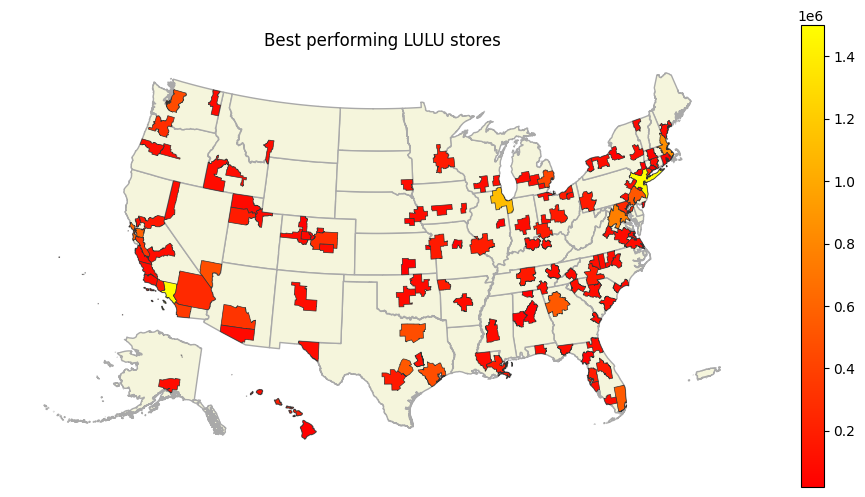

In [ ]:
# Plot CBSAs depicting weekly sales for LULU
plot(gdf_lulu_cbsas_aggregated, 'store_weekly_volume', 'Best performing CBSAs for LULU', 20000, 1500000)

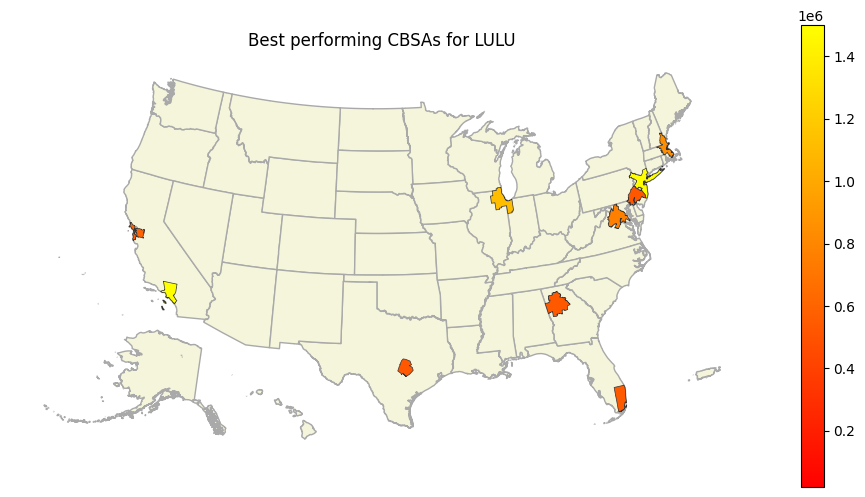

In [ ]:
# Plot top 10 CBSAs depicting weekly sales for LULU
plot( gdf_lulu_cbsas_aggregated.nlargest(10, 'store_weekly_volume'),
     'store_weekly_volume', 'Best performing CBSAs for LULU', 20000, 1500000)

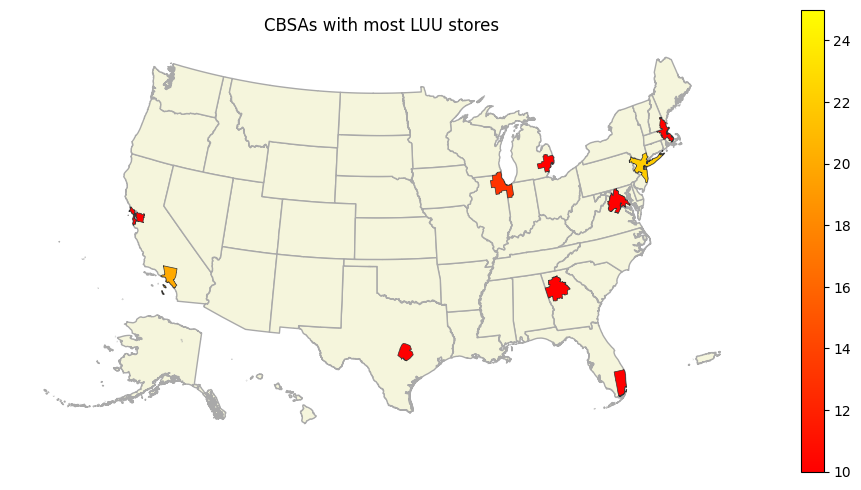

In [ ]:
# Plot top 10 CBSAs with most LULU stores
plot(gdf_lulu_cbsas_aggregated.nlargest(10, 'store_count'),
     'store_count', 'CBSAs with most LUU stores', 10, 25)

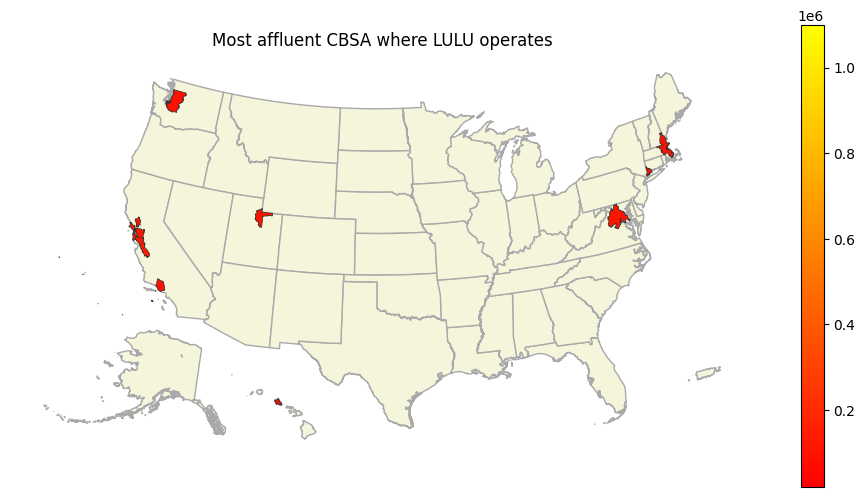

In [ ]:
# Plot top 10 CBSAs where LULU operates with highest median household income
plot( gdf_lulu_cbsas_aggregated.nlargest(10, 'median_household_income'),
     'median_household_income', 'Most affluent CBSA where LULU operates', 20000, 1100000)

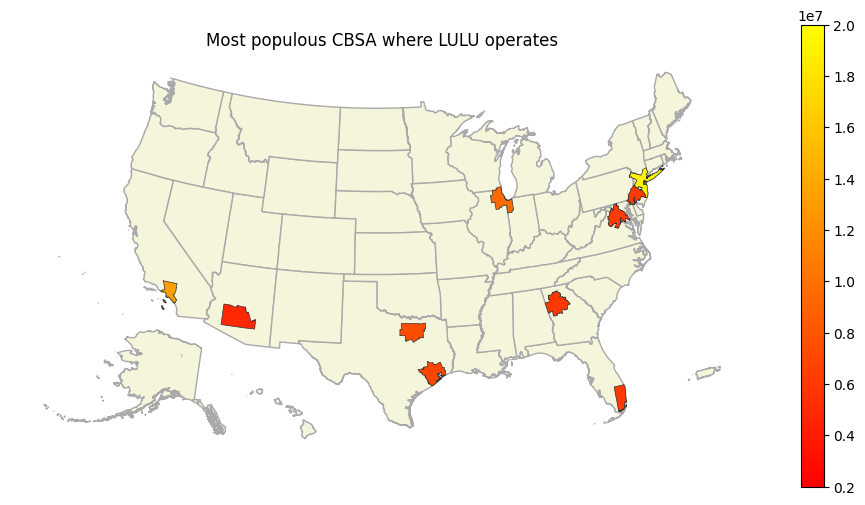

In [ ]:
# Plot top 10 most populous CBSAs where LULU operates
plot( gdf_lulu_cbsas_aggregated.nlargest(10, 'popuation'),
     'popuation', 'Most populous CBSA where LULU operates', 2000000, 20000000)

In [ ]:
# The real value is stitching the LULU sales and demographic data together
# Because you can now run sophistacated models to determine what demographic factors drie LULU sales
gdf_lulu_cbsas_aggregated.nlargest(20, 'store_weekly_volume')

,geometry,store_weekly_volume,square_footage,median_household_income,popuation,median_female_age,store_count,state
cbsa_code,,,,,,,,
35620,"MULTIPOLYGON (((-74.24252 40.51831, -74.24103 ...",1960520,61100,81951.0,19261570.0,40.3,22,NJ
31080,"MULTIPOLYGON (((-118.57988 33.03446, -118.5739...",1812880,62825,76399.0,13211027.0,38.3,20,CA
16980,"POLYGON ((-88.93922 42.09058, -88.93929 42.097...",1113710,38300,74621.0,9478801.0,38.9,13,IL
14460,"MULTIPOLYGON (((-70.95784 42.30983, -70.95809 ...",839450,26400,93537.0,4854808.0,40.1,10,MA
47900,"POLYGON ((-78.44553 38.48770, -78.44438 38.489...",757330,29925,106415.0,6250309.0,38.1,10,VA
41860,"MULTIPOLYGON (((-122.99875 37.69744, -123.0027...",589240,20900,110837.0,4709220.0,40.1,7,CA
33100,"MULTIPOLYGON (((-80.61448 25.18231, -80.61232 ...",544460,23600,59030.0,6129858.0,42.9,8,FL
12060,"POLYGON ((-85.31257 33.90066, -85.30879 33.900...",537380,17700,71193.0,5947008.0,37.6,6,GA
12420,"POLYGON ((-98.27084 30.10674, -98.26345 30.126...",533310,17400,80852.0,2173804.0,35.6,6,TX


**Appendix - data available from Census Bureau**

Following cells demonstrate the richness and depth of the demographic data available from Census Bureau

In [ ]:
# All the groups of metrics available in just one, the annual
# community survey data from census bureau
df_groups = ced.variables.all_groups('acs/acs5', 2020)
df_groups

,DATASET,YEAR,GROUP,DESCRIPTION
0,acs/acs5,2020,B01001,SEX BY AGE
1,acs/acs5,2020,B01001A,SEX BY AGE (WHITE ALONE)
2,acs/acs5,2020,B01001B,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE)
3,acs/acs5,2020,B01001C,SEX BY AGE (AMERICAN INDIAN AND ALASKA NATIVE ...
4,acs/acs5,2020,B01001D,SEX BY AGE (ASIAN ALONE)
...,...,...,...,...
1135,acs/acs5,2020,C27014,PUBLIC HEALTH INSURANCE BY WORK EXPERIENCE
1136,acs/acs5,2020,C27016,HEALTH INSURANCE COVERAGE STATUS BY RATIO OF I...
1137,acs/acs5,2020,C27017,PRIVATE HEALTH INSURANCE BY RATIO OF INCOME TO...
1138,acs/acs5,2020,C27018,PUBLIC HEALTH INSURANCE BY RATIO OF INCOME TO ...


In [ ]:
# Many variables available for "median age"
df_groups[df_groups['DESCRIPTION'].str.contains('MEDIAN AGE')]

,DATASET,YEAR,GROUP,DESCRIPTION
10,acs/acs5,2020,B01002,MEDIAN AGE BY SEX
11,acs/acs5,2020,B01002A,MEDIAN AGE BY SEX (WHITE ALONE)
12,acs/acs5,2020,B01002B,MEDIAN AGE BY SEX (BLACK OR AFRICAN AMERICAN A...
13,acs/acs5,2020,B01002C,MEDIAN AGE BY SEX (AMERICAN INDIAN AND ALASKA ...
14,acs/acs5,2020,B01002D,MEDIAN AGE BY SEX (ASIAN ALONE)
15,acs/acs5,2020,B01002E,MEDIAN AGE BY SEX (NATIVE HAWAIIAN AND OTHER P...
16,acs/acs5,2020,B01002F,MEDIAN AGE BY SEX (SOME OTHER RACE ALONE)
17,acs/acs5,2020,B01002G,MEDIAN AGE BY SEX (TWO OR MORE RACES)
18,acs/acs5,2020,B01002H,"MEDIAN AGE BY SEX (WHITE ALONE, NOT HISPANIC O..."
19,acs/acs5,2020,B01002I,MEDIAN AGE BY SEX (HISPANIC OR LATINO)


In [ ]:
# Various 'cuts' available on single variable
ced.variables.all_variables('acs/acs5', 2020, 'B01002')

,YEAR,DATASET,GROUP,VARIABLE,LABEL,SUGGESTED_WEIGHT,VALUES
0,2020,acs/acs5,B01002,B01002_001E,Estimate!!Median age --!!Total:,NaN,None
1,2020,acs/acs5,B01002,B01002_002E,Estimate!!Median age --!!Male,NaN,None
2,2020,acs/acs5,B01002,B01002_003E,Estimate!!Median age --!!Female,NaN,None


**Granularity of the data**

On-spine geometry drill-down

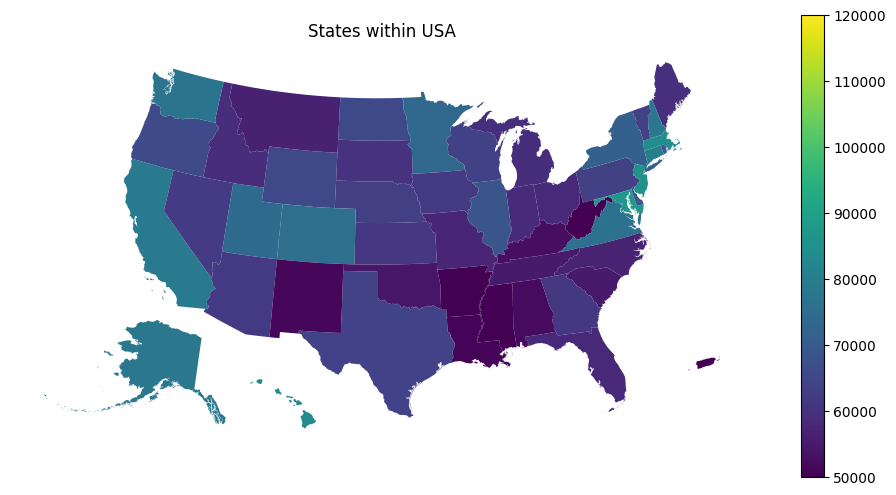

In [ ]:
# States within USA
gdf_drilldown_states = ced.download(
    # These first three arguments are positional and required
    # so sometimes I skip naming them.
    dataset='acs/acs5',
    vintage=2020,

    # Note: 'B03002_001E' is the variable for total population.
    # B03002_001E is the vaiable for median household income
    # B01002_003E is the variable for median age for females
    download_variables=['NAME', 'B19013_001E'],

    # Query all CBSAs in the country.
    state='*',

    with_geometry=True
)

# Plot them on the map
ax = cem.plot_us(
    gdf_drilldown_states,
    'B19013_001E',

    vmin=50000,
    vmax=120000,

    # The **kwargs here are standard Matplotlib **kwargs
    legend=True,
    figsize=(12, 6)
)

ax.axis('off')
_ = ax.set_title("States within USA")

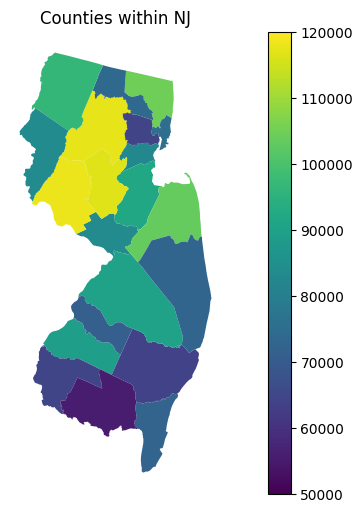

In [ ]:
# Counties within NJ
gdf_drilldown_counties = ced.download(
    # These first three arguments are positional and required
    # so sometimes I skip naming them.
    dataset='acs/acs5',
    vintage=2020,

    # Note: 'B03002_001E' is the variable for total population.
    # B03002_001E is the vaiable for median household income
    # B01002_003E is the variable for median age for females
    download_variables=['NAME', 'B19013_001E'],

    # Query all CBSAs in the country.
    state=states.NJ,
    county='*',

    with_geometry=True
)

# Plot them on the map
ax = cem.plot_us(
    gdf_drilldown_counties,
    'B19013_001E',

    vmin=50000,
    vmax=120000,

    # The **kwargs here are standard Matplotlib **kwargs
    legend=True,
    figsize=(12, 6)
)

ax.axis('off')
_ = ax.set_title("Counties within NJ")

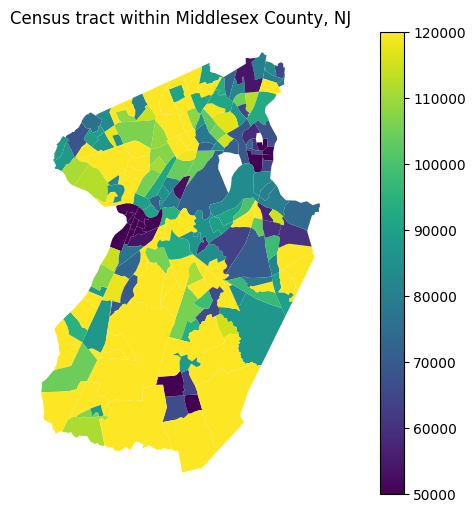

In [ ]:
# Census tracts within Middlesex county, NJ
gdf_drilldown_tracts = ced.download(
    # These first three arguments are positional and required
    # so sometimes I skip naming them.
    dataset='acs/acs5',
    vintage=2020,

    # Note: 'B03002_001E' is the variable for total population.
    # B03002_001E is the vaiable for median household income
    # B01002_003E is the variable for median age for females
    download_variables=['NAME', 'B19013_001E'],

    # Query all CBSAs in the country.
    state=states.NJ,
    county='023',
    tract='*',

    with_geometry=True
)

# Plot them on the map
ax = cem.plot_us(
    gdf_drilldown_tracts,
    'B19013_001E',

    vmin=50000,
    vmax=120000,

    # The **kwargs here are standard Matplotlib **kwargs
    legend=True,
    figsize=(12, 6)
)

ax.axis('off')
_ = ax.set_title("Census tract within Middlesex County, NJ")

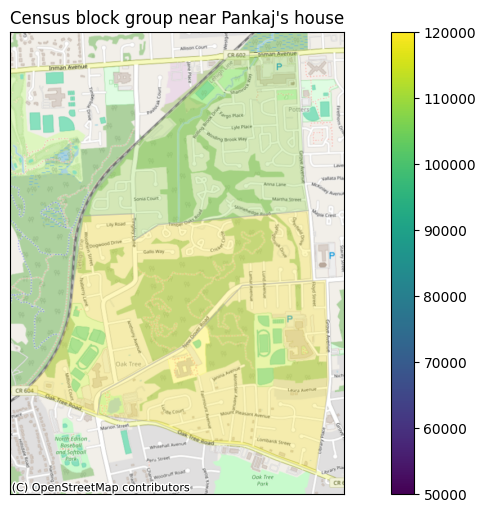

In [ ]:
# Census block groups near Pankaj's home
ax = cem.plot_map(
    gdf_drilldown_block_group,
    'B19013_001E',

    vmin=50000,
    vmax=120000,
    edgecolor='darkgrey',

    figsize=(12, 6),
    legend=True,

    alpha=0.3,

    # Add a background map from
    # Open Street Maps
    with_background=True
)

ax.set_title("Census block group near Pankaj's house")
None

In [ ]:
# Rich list of geometry drilldown available in census bureau data
list(ced.geographies('acs/acs5', 2020))

[['us'],
 ['region'],
 ['division'],
 ['state'],
 ['state', 'county'],
 ['state', 'county', 'county_subdivision'],
 ['state', 'county', 'county_subdivision', 'subminor_civil_division'],
 ['state', 'county', 'county_subdivision', 'place_remainder_or_part'],
 ['state', 'county', 'tract'],
 ['state', 'county', 'tract', 'block_group'],
 ['state', 'place', 'county_or_part'],
 ['state', 'place'],
 ['state', 'consolidated_city'],
 ['state', 'consolidated_city', 'place_or_part'],
 ['state', 'alaska_native_regional_corporation'],
 ['american_indian_area_alaska_native_area_hawaiian_home_land'],
 ['american_indian_area_alaska_native_area_hawaiian_home_land',
  'tribal_subdivision_remainder'],
 ['american_indian_area_alaska_native_area_reservation_or_statistical_entity_only'],
 ['american_indian_area_off_reservation_trust_land_only_hawaiian_home_land'],
 ['american_indian_area_alaska_native_area_hawaiian_home_land',
  'tribal_census_tract'],
 ['american_indian_area_alaska_native_area_hawaiian_home